In [1]:
import torchhd

from src.datasets.qm9_smiles_generation import QM9Smiles
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.data import Dataset

from src.datasets.zinc_smiles_generation import ZincSmiles
from src.encoding.configs_and_constants import SupportedDataset
from src.utils.utils import GLOBAL_DATASET_PATH


def analyze_dataset(ds: Dataset, name: str = "", feature_attr: str = "x") -> dict:
    """
    Compute statistics for a PyG dataset with 4-tuple node features
    and draw histograms for node counts, edge counts, and node-type distribution.
    """
    num_nodes_list, num_edges_list = [], []
    node_type_counter = Counter()
    logp_list = ds.logp.tolist()
    qed_list = ds.qed.tolist()
    sa_score_list = ds.sa_score.tolist()
    max_ring_size_list = ds.max_ring_size.tolist()

    for data in ds:
        n = int(data.num_nodes)
        e = int(data.num_edges) // 2  # dataset is undirected
        num_nodes_list.append(n)
        num_edges_list.append(e)

        x: torch.Tensor = getattr(data, feature_attr)
        if x.dim() != 2 or x.size(1) != 4:
            raise ValueError(f"Expected {feature_attr} shape [N, 4], got {tuple(x.shape)}")
        rows = x.detach().cpu().to(torch.int64).tolist()
        node_type_counter.update(map(tuple, rows))

        # --- logP (optional) ---
        if hasattr(data, "logp"):
            lp = data.logp
            # accept scalar tensor or 1-element tensor
            if isinstance(lp, torch.Tensor):
                lp = float(lp.detach().cpu().reshape(-1)[0])
            else:
                lp = float(lp)
            logp_list.append(lp)

    def stats(arr):
        arr = np.asarray(arr)
        return {
            "min": int(arr.min()),
            "max": int(arr.max()),
            "mean": float(arr.mean()),
            "median": float(np.median(arr)),
            "std": float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        }

    summary = {
        "dataset": name,
        "num_graphs": len(ds),
        "nodes": stats(num_nodes_list),
        "edges": stats(num_edges_list),
        "total_node_types": len(node_type_counter),
        "node_type_distribution": dict(node_type_counter),
    }

    if logp_list:
        summary["logp"] = stats(logp_list)
        summary["qed"] = stats(qed_list)
        summary["sa_score"] = stats(sa_score_list)
        summary["max_ring_size"] = stats(max_ring_size_list)


    # --- plotting ---
    fig = plt.figure(figsize=(16, 10))  # wider and taller canvas
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 3])  # bottom row 3x taller

    ax_nodes = fig.add_subplot(gs[0, 0])
    ax_edges = fig.add_subplot(gs[0, 1])
    ax_types = fig.add_subplot(gs[1, :])  # spans the whole width

    # Add a little more margin at the bottom so rotated labels fit
    plt.subplots_adjust(bottom=0.25)

    # Node count distribution
    ax_nodes.hist(num_nodes_list, bins=30, color="steelblue", edgecolor="black")
    ax_nodes.set_title(f"{name} – Node count distribution")
    ax_nodes.set_xlabel("num_nodes")
    ax_nodes.set_ylabel("frequency")

    # Edge count distribution
    ax_edges.hist(num_edges_list, bins=30, color="darkorange", edgecolor="black")
    ax_edges.set_title(f"{name} – Edge count distribution")
    ax_edges.set_xlabel("num_edges")
    ax_edges.set_ylabel("frequency")

    # Node type distribution (wider)
    if node_type_counter:
        labels, counts = zip(*node_type_counter.most_common())
        ax_types.bar(range(len(labels)), counts, color="seagreen", edgecolor="black")
        ax_types.set_xticks(range(len(labels)))
        ax_types.set_xticklabels([str(l) for l in labels], rotation=90, fontsize=8)
    ax_types.set_title(f"{name} – Node type distribution")
    ax_types.set_xlabel("node type (tuple)")
    ax_types.set_ylabel("count")

    plt.tight_layout()
    plt.show()

    # --- separate logP plot (only if available) ---
    if logp_list:
        fig2 = plt.figure(figsize=(8, 5))
        ax_logp = fig2.add_subplot(1, 1, 1)
        ax_logp.hist(logp_list, bins=100, edgecolor="black")
        ax_logp.set_title(f"{name} – logP distribution")
        ax_logp.set_xlabel("cLogP (RDKit)")
        ax_logp.set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    if qed_list:
        fig2 = plt.figure(figsize=(8, 5))
        ax_logp = fig2.add_subplot(1, 1, 1)
        ax_logp.hist(qed_list, bins=100, edgecolor="black")
        ax_logp.set_title(f"{name} – QED distribution")
        ax_logp.set_xlabel("QED (RDKit)")
        ax_logp.set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    if sa_score_list:
        fig2 = plt.figure(figsize=(8, 5))
        ax_logp = fig2.add_subplot(1, 1, 1)
        ax_logp.hist(sa_score_list, bins=100, edgecolor="black")
        ax_logp.set_title(f"{name} – SA-Score distribution")
        ax_logp.set_xlabel("SA-Score (RDKit)")
        ax_logp.set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    return summary


/home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/torch_scatter/_version_cuda.so
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


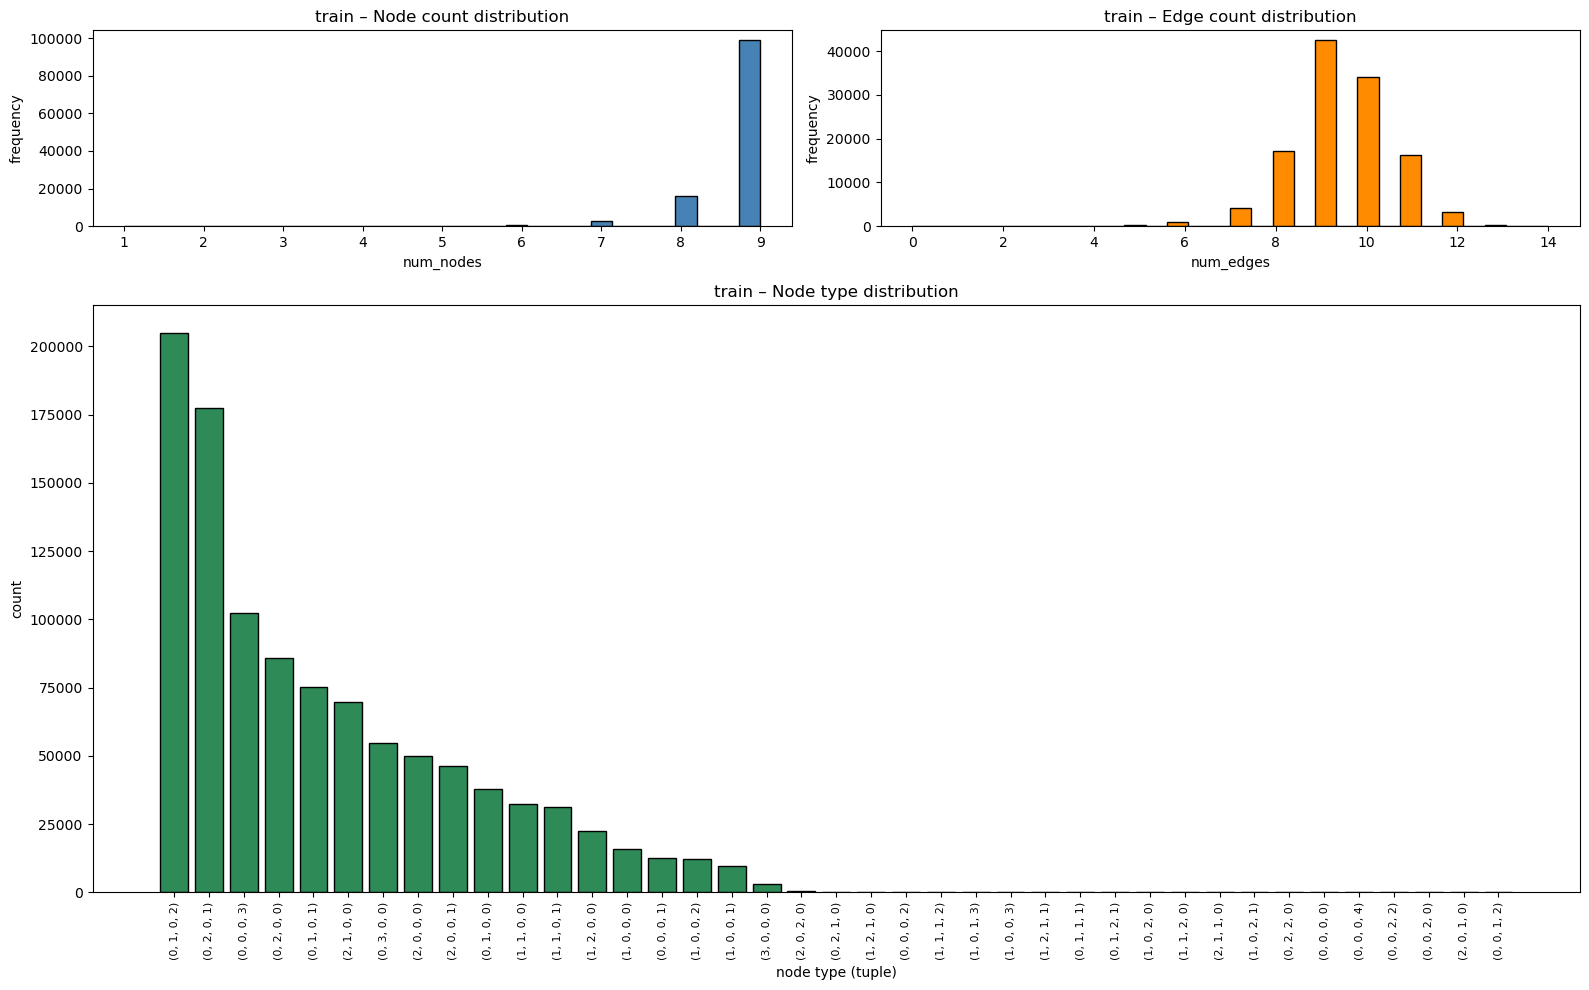

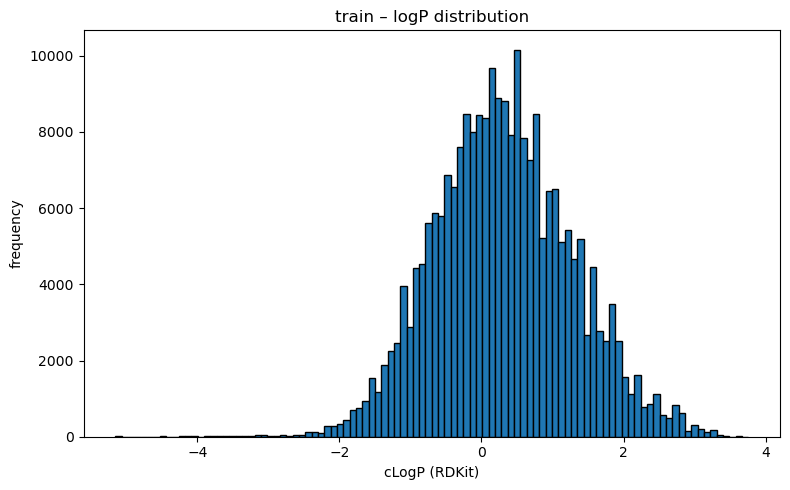

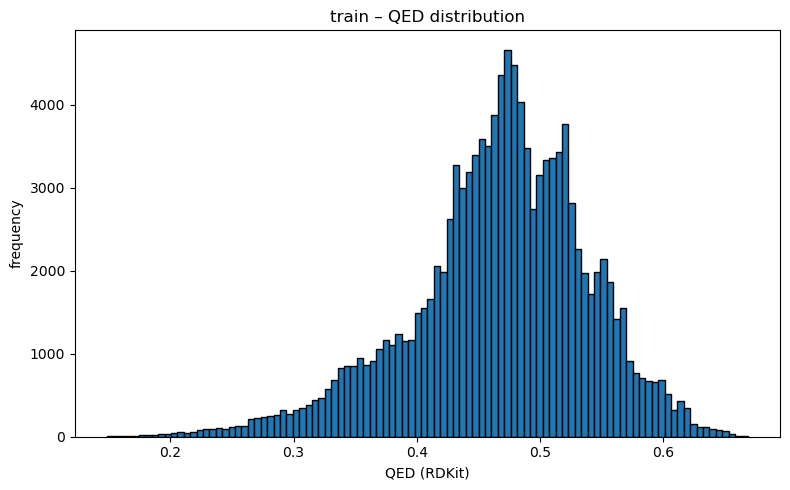

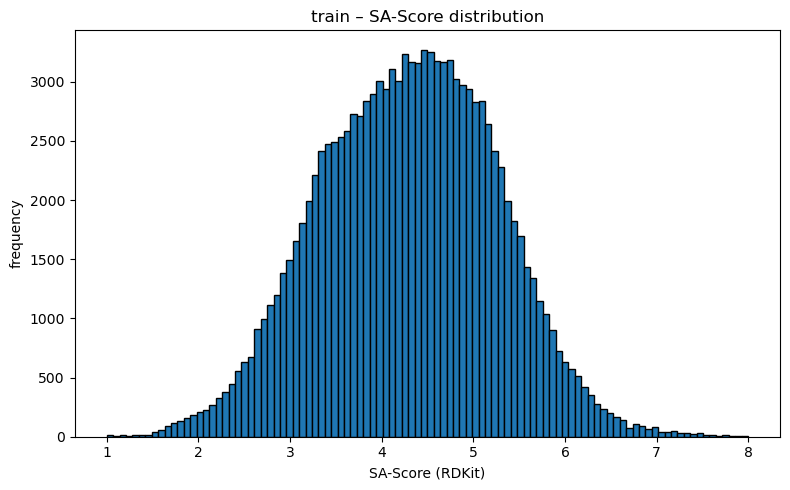

{'dataset': 'train',
 'edges': {'max': 14,
           'mean': 9.396537655935868,
           'median': 9.0,
           'min': 0,
           'std': 1.1682700245850308},
 'logp': {'max': 3,
          'mean': 0.30487121410781287,
          'median': 0.27810001373291016,
          'min': -5,
          'std': 0.9661956285099275},
 'max_ring_size': {'max': 9,
                   'mean': 4.210642754397329,
                   'median': 5.0,
                   'min': 0,
                   'std': 1.7229798089811252},
 'node_type_distribution': {(0, 0, 0, 0): 2,
                            (0, 0, 0, 1): 12653,
                            (0, 0, 0, 2): 92,
                            (0, 0, 0, 3): 102500,
                            (0, 0, 0, 4): 1,
                            (0, 0, 1, 2): 1,
                            (0, 0, 2, 0): 1,
                            (0, 0, 2, 2): 1,
                            (0, 1, 0, 0): 37875,
                            (0, 1, 0, 1): 75277,
                     

In [3]:
from pprint import pprint

for split in ["train",
              # "valid", "test"
              ]:
    ds = QM9Smiles(split=split, enc_suffix="HRR1600")
    stats = analyze_dataset(ds, name=split)
    pprint(stats)

torch.Size([1000, 1600])
Mean cosine similarity: 0.0432
Std  cosine similarity: 0.1517


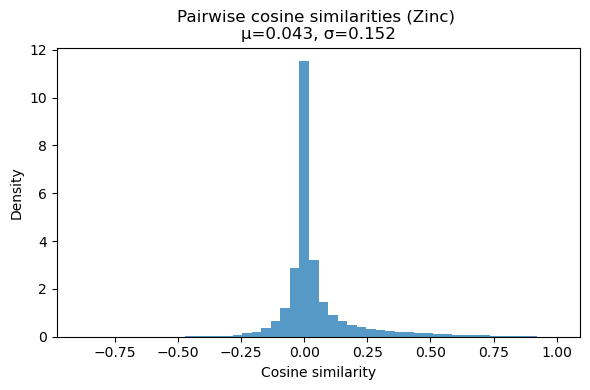

torch.Size([1000, 1600])
Mean cosine similarity: 0.1824
Std  cosine similarity: 0.1460


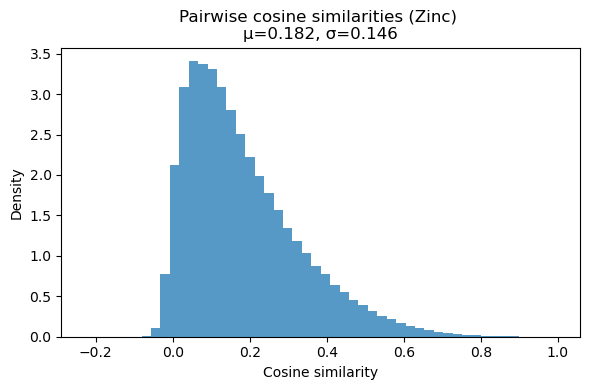

In [5]:
import torchhd

for dataset in [
    SupportedDataset.QM9_SMILES_HRR_1600_F64_G1G3,
    SupportedDataset.QM9_SMILES_HRR_1600_F64_G1NG3
]:

    ds = QM9Smiles(split="train", enc_suffix=dataset.default_cfg.name)

    # Number of samples
    n_samples = 1000

    # Ensure reproducibility
    idxs = torch.randperm(len(ds))[:n_samples]

    # Collect graph_terms for sampled items
    graph_terms = torch.stack([ds[i].graph_terms for i in idxs])  # shape [1000, D]
    print(graph_terms.shape)

    # Pairwise cosine similarity matrix [1000, 1000]
    cos = torchhd.cos(graph_terms, graph_terms)

    # keep only unique, off-diagonal cosine similarities
    i, j = torch.triu_indices(cos.size(0), cos.size(1), offset=1)
    cs = cos[i, j]  # shape [N*(N-1)/2]

    # compute stats
    mean_cs = cs.mean().item()
    std_cs = cs.std(unbiased=True).item()

    print(f"Mean cosine similarity: {mean_cs:.4f}")
    print(f"Std  cosine similarity: {std_cs:.4f}")

    # plot
    plt.figure(figsize=(6, 4))
    plt.hist(cs.cpu().numpy(), bins=50, density=True, alpha=0.75)
    plt.xlabel("Cosine similarity")
    plt.ylabel("Density")
    plt.title(f"Pairwise cosine similarities (Zinc) \nμ={mean_cs:.3f}, σ={std_cs:.3f}")
    plt.tight_layout()
    plt.show()

In [ ]:
ds = QM9Smiles(split="train")
data = ds[103]
data.x


In [ ]:
data.edge_index

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def is_fully_connected(data, undirected: bool = True) -> bool:
    """
    Check if a PyG ``Data`` graph is fully connected.

    :param data: PyG graph.
    :param undirected: If ``True``, treat edges as undirected when checking connectivity.
    :returns: ``True`` if the graph has exactly one connected component (or 0/1 nodes), else ``False``.
    """
    if data.num_nodes <= 1:
        return True
    G = to_networkx(data, to_undirected=undirected)
    # For empty edge sets, NX still handles connectivity via components:
    return nx.number_connected_components(G) == 1

not_connected_idxs = []
for i, data in enumerate(ds):
    # Assume you have a PyG Data object `data`
    G = to_networkx(data, to_undirected=True)
    if not is_fully_connected(data):
        not_connected_idxs.append(i)
        print(f"Graph {i} is not fully connected")
        # Optionally add node labels or features
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
        plt.show()
print(len(not_connected_idxs))


### BAD NEWS: 202 Graphs are not fully connected.

In [2]:
from torch_geometric.datasets import QM9
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def is_fully_connected(data, undirected: bool = True) -> bool:
    """
    Check if a PyG ``Data`` graph is fully connected.

    :param data: PyG graph.
    :param undirected: If ``True``, treat edges as undirected when checking connectivity.
    :returns: ``True`` if the graph has exactly one connected component (or 0/1 nodes), else ``False``.
    """
    if data.num_nodes <= 1:
        return True
    G = to_networkx(data, to_undirected=undirected)
    # For empty edge sets, NX still handles connectivity via components:
    return nx.number_connected_components(G) == 1

pyg_not_connected_idxs = []
for i, data in enumerate(QM9(root=GLOBAL_DATASET_PATH / "PYG_QM9")):
    # Assume you have a PyG Data object `data`
    G = to_networkx(data, to_undirected=True)
    if not is_fully_connected(data):
        pyg_not_connected_idxs.append(i)
print(f"PYG - QM9 - {len(pyg_not_connected_idxs)} graphs are not fully connected")
print(pyg_not_connected_idxs)


for split in ["train", "valid", "test"]:
    not_connected_idxs = []
    for i, data in enumerate(QM9Smiles(split=split)):
        # Assume you have a PyG Data object `data`
        G = to_networkx(data, to_undirected=True)
        if not is_fully_connected(data):
            not_connected_idxs.append(i)
    print(f"QM9 - {split} - {len(not_connected_idxs)} graphs are not fully connected")
    print(not_connected_idxs)




for split in ["train", "valid", "test"]:
    not_connected_idxs = []
    for i, data in enumerate(ZincSmiles(split=split)):
        # Assume you have a PyG Data object `data`
        G = to_networkx(data, to_undirected=True)
        if not is_fully_connected(data):
            not_connected_idxs.append(i)
    print(f"ZINC - {split} - {len(not_connected_idxs)} graphs are not fully connected")
    print(not_connected_idxs)


### BAD NEWS: 202 Graphs are not fully connected.

Extracting /home/akaveh/Projects/kit/graph_hdc/_datasets/PYG_QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [01:57<00:00, 1139.37it/s]
Done!


PYG - QM9 - 0 graphs are not fully connected
[]
QM9 - train - 202 graphs are not fully connected
[103, 1251, 1593, 1851, 1995, 2295, 4099, 4531, 5216, 5221, 5834, 6145, 8286, 8491, 8949, 9125, 9999, 11232, 12131, 12542, 12740, 13217, 13876, 14195, 14485, 14558, 16087, 16570, 17058, 17153, 17628, 17836, 17909, 18422, 18466, 18561, 18971, 19381, 19426, 19564, 19832, 19974, 20572, 20809, 20834, 21226, 21576, 22407, 24078, 24171, 25407, 25458, 25886, 26227, 26466, 26496, 26944, 27140, 27460, 27518, 27741, 30253, 30839, 32067, 32967, 33555, 34331, 34804, 35030, 35529, 35781, 36068, 36764, 37067, 37070, 37358, 37987, 38571, 41050, 41652, 41713, 41962, 43185, 44361, 44818, 45095, 45294, 45322, 45984, 46272, 46345, 46633, 47233, 47950, 48911, 48936, 50163, 51300, 51823, 52411, 52847, 53366, 53487, 53862, 55836, 56449, 58667, 59069, 59243, 61063, 61196, 61961, 62382, 63267, 63276, 64004, 64281, 64647, 64868, 64974, 65499, 66551, 66632, 66768, 67243, 69640, 70128, 70464, 71456, 72377, 72457, 726

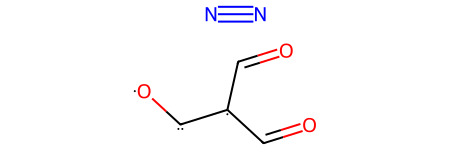

N#N.[O][C][C](C=O)C=O


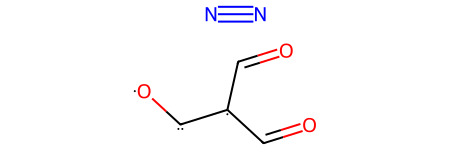

N#N.O=C=C(C=O)C=O


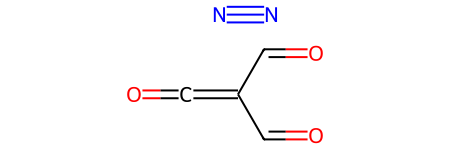

In [9]:
from rdkit import Chem

bad_smile = "N#N.[O][C][C](C=O)C=O"
mol = Chem.MolFromSmiles(bad_smile)
display(mol)

qm9_103 = QM9Smiles(split="train")[103]
print(qm9_103.smiles)
mol_103 = Chem.MolFromSmiles(qm9_103.smiles)
display(mol_103)

mol_103_eval = Chem.MolFromSmiles(qm9_103.eval_smiles)
print(qm9_103.eval_smiles)
display(mol_103_eval)

In [6]:
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_qm9()
train, valid, test = datasets
df = train.to_dataframe()
print(df.columns)



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/p

ValueError: Must pass 2-d input. shape=(105984, 29, 29)